# Perceived Causality in Schizophrenia Spectrum Disorder
... and some Bayesian Generalized Linear Regression.

Welcome! This notebook provides you with some background about causality perception and modelling!

Table of content:

1. Load and inspect the data
2. Model definition
3. Data pre-processing
4. Model implementation and fitting
5. Checking convergence and visualizing model parameter distributions
6. Making some predictions
7. Model comparison
8. What is left to do

Depending on your familiarity with these topics, going through the notebook and understanding the data and code, should take 30 min to 1.5 hours.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
from jax.scipy.special import expit
from jax import random
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import arviz as az

DATA_PATH = "../data/Causality_tDCS_sample.csv"
rng_key = random.key(1133555)

c:\Users\key\Documents\cogSci\IICCSSS\hackathon\topic4_proballistic_programming\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and inspect the data

We first need to get an overview of our data and understand what each variable means. Before continuing though, you should first get an overview of the experiment, understand the task and the procedure. You can find a very brief summary here and have a look at one of the papers for more details.

**Experiment summary**

Participants were observing simulated Michotte Launching Events where a blue disk moves towards a red one, comes into contact with it, stops and then the red one starts moving. They gave binary judgements whether they perceived the event as causal or non-causal. <br>
Participants either belonged to a ``group`` of patients being treated for Schizophrenia Spectrum Disorder (SSD) or a healthy control (HC) group. <br>
In each trial the red disk moved with a certain ``angle`` of egress and a certain ``delay`` after the contact. <br>
Each participant repeated the same 98 trials on different days. They did 48 trials first, then a transcranial direct current stimulation (tDCS) was applied, then they did the same 48 trials again. On each day the stimulation was applied to a different brain area. HCs took part in 7 different ``stimulation``s, SSDs only in 4 different stimulations. <br>
Foreach trial the given `causality_judgement` and the response time (`RT`) was collected.

Related papers for more details and figures:

* Streiling, K., Schülke, R., Straube, B. et al. Choice- and trial-history effects on causality perception in Schizophrenia Spectrum Disorder. Schizophr 11, 65 (2025). https://doi.org/10.1038/s41537-025-00614-0
* Schülke R, Schmitter CV, Straube B. Improving causality perception judgments in schizophrenia spectrum disorder via transcranial direct current stimulation. J Psychiatry Neurosci. 2023 Jul 4;48(4):E245-E254. doi: https://10.1503/jpn.220184. Erratum in: J Psychiatry Neurosci. 2024 Apr 23;49(2):E144. doi: 10.1503/jpn.240042. PMID: 37402578; PMCID: PMC10322162.

In [2]:
# read in data
df = pd.read_csv(DATA_PATH, sep="\t")
df

,subject_id,selection_matching,baseline_stimulation,stimulation,group,time,angle,causality_judgement,RT,trialnumber,RT_corrected_for_delay,error_responses
0,2.0,1,1.0,1.0,0.0,4.0,"22,5",1.0,"1557,1",1.0,"1490,46",0
1,2.0,1,1.0,1.0,0.0,0.0,30,1.0,"1480,6",2.0,"1480,6",0
2,2.0,1,1.0,1.0,0.0,16.0,"22,5",0.0,1615,3.0,"1348,44",0
3,2.0,1,1.0,1.0,0.0,0.0,0,1.0,"1395,2",4.0,"1395,2",0
4,2.0,1,1.0,1.0,0.0,8.0,"22,5",0.0,"1530,4",5.0,"1397,12",0
...,...,...,...,...,...,...,...,...,...,...,...,...
53989,120.0,1,2.0,7.0,1.0,16.0,45,0.0,"1930,9",95.0,"1664,34",0
53990,120.0,1,2.0,7.0,1.0,6.0,0,1.0,"1706,4",96.0,"1606,44",0
53991,120.0,1,2.0,7.0,1.0,4.0,0,1.0,"1720,5",97.0,"1653,86",0
53992,120.0,1,2.0,7.0,1.0,2.0,"22,5",1.0,"1719,9",98.0,"1686,58",0


**Data columns**

* `subject_id`: The ID of each participant. IDs below 100 belong to HCs.
* `selection_matching`: There were more HCs than SSDs. This column selects a subet of th HCs (`selection_match=1`) to make both groups demographically comparable
* `baseline_stimulation`: 1: trial was before the tDCS stimulation, 2: trial was after the stimulation
* `stimulation`: Type of stimulation applied
  * 1=LFC-RFA, 2=LFA-RFC, 3=LPC-RPA, 4=LPA-RPC, 5=LFC-RPA, 6=LFA-RPC, 7=sham 
  * where LFC = left frontal cathode, RFA=right frontal anode, LPC=left parietal cathode, etc.
* ``group``: 0: healthy control group, 1: patients with SSD
* ``time``: delay in frames between the contact of the blue ball and the start of the movement of the red
* `angle`: angle of egress (in degree) of the red ball's movement relative to the blue balls movement
* `causality_judgement`: 0: non causal, 1: causal
* `RT`: reaction time
* `trial number`: trial sequence identifier
* `RT_corrected_for_delay`: reaction time but corrected for the delay (value in `time`) of the trial
* `error_responses`: 0: valid response, 1: erroneous response, e.g. multiple answers were given. 

## 2. Model definition

We can now pose a question about this data, for example: 

                Do delay and angle influence the causality judgement differently for SSDs and HCs?              

#### Putting the Generalized into Linear Models
To answer this question with the data, we can make apply a range of ANOVAs, t-tests or Wilcoxon signed rank tests. An alternative is perform a sort of regression and see how the values of our variables (angle, time and group) influence the binary decision (causality_judgement). This sort of regression is called a *Generalized Model*. For starters, and because we have no other prior expectations, we can siimply assume a linear relation between angle and time, which makes the model a *Generalized Linear Model*.

The generalization comes from the fact that our dependent variable is binary, thus, we need a link function to link a real value (-$\infty$ to $+\infty$) to a value between 0 and 1 that we can interpret as the probability of one kind of response, e.g. the probability of responding "causal". Typically, we use the [logistic (or sigmoid or expit) function](https://en.wikipedia.org/wiki/Logistic_function) as link function:

$$p(x) = \frac{1}{1+e^{-x}}$$

where
* $x$ is the (linear) combination of our independent variables
* $p$ is the probability of responding "causal"

#### A lot of choices

The one challenge with any sort of (statistical) modelling is, that there is no single (statistical) model to rule the all. Here, for example, we have many choices how to combine our three variables (angle, time and group). 

**Starting somewhere** <br>
The naive way would be to assign each variable a *weight* and combine them linearly and add an offset to get our input ($x$) to the logistic function above:

$$x_t = \theta + \alpha \cdot angle_t + \beta \cdot time_t + \gamma \cdot group_t$$

where 
* $x_t$ is the logit (input to the logistic function) at trial $t$
* $angle_t$, $time_t$, $group_t$ are the values of the three variables at trial $t$
* $\theta$ is the offset
* $\alpha$, $\beta$, $\gamma$ are the weights assign to the respective variable

**Remembering the question** <br>
If we look back to our question above however, we remember that we were actually interested in the *interaction* between the group and the effects of angle and time. <br>
To include this interaction we could, for example, add a group specific offset to the angle and time weights:

$$x_t = \theta + (\alpha + \alpha_g \cdot group) \cdot angle_t + (\beta + \beta_g \cdot group) \cdot time_t + \gamma \cdot group_t$$

where
* $\alpha_g$ is added to the weight of the angle ($\alpha$) depending on the value of group. <br> 
    To make the example clearer, we have mainly two ways of encoding the groups (HCs and SSD), that also slightly change the meaning of the weights:
  * If our group encodes HCs as 0 and SSDs as 1, then $\alpha_g$ is added to $\alpha$ if the participant is of the group SSD.
  * If our group encodes HCs as -1 and SSDs as 1, then $\alpha_g$ is added to $\alpha$ if the participant is of the group SSD and subtracted from $\alpha$ if the participant is of the group HC.

The equivalent explanation holds for the weight $\beta$.

Now, with that we have already defined two models and can now implement them in our favourite probabilistic programmin framework and compare them.

## 3. Data pre-processing

### Housekeeping - Filtering and checking

In order to do the fitting, we have to prepare our data a little bit.

First, we select the subset of healthy controls marked by the `selection_matching` column.

In [3]:
df = df[df["selection_matching"] == "1"]
# drop the column as it has no more information
df = df.drop(columns=["selection_matching"])

Then, in order to balance the two datasets, we only and keep data from those tDCS stimulation sessions that were conducted on both groups (session 1, 3, 5 and 7).

In [4]:
df = df[df["stimulation"].isin([1,3,5,7])]

Then we drop those trials that were marked as potentially erroneous.

In [5]:
df = df[df["error_responses"] == 0]
# drop the column as it has no more information
df = df.drop(columns=["error_responses"])

It seems that there is still one "weird" trial with a causality_judgement of 3...

In [6]:
df["causality_judgement"].value_counts()

causality_judgement
0.0    16172
1.0    15043
3.0        1
Name: count, dtype: int64

... so we drop this one too.

In [7]:
df = df[df["causality_judgement"].isin([0,1])]

Finally, our data is still not very clean. I.e. the angle and reaction time values are actually strings with the decimal sign being a German "," instead of a ".".
We can see this when we look at the DataFrame's dtypes:

In [8]:
df.dtypes

subject_id                float64
baseline_stimulation      float64
stimulation               float64
group                     float64
time                      float64
angle                      object
causality_judgement       float64
RT                         object
trialnumber               float64
RT_corrected_for_delay     object
dtype: object

So, we replace the decimal sign in these columns and convert them to floating point numbers:

In [9]:
for col in ["angle", "RT", "RT_corrected_for_delay"]:
    df[col] = list(map(lambda x: x.replace(",", "."), df[col]))
    df[col] = df[col].astype(float)

### Normalization

Now, one trick to make these models find a solution quicker is to scale your data (or "normalize" it), i.e. compress it to a space somewhat close to zero in a meaningful way. <br>
We are left with only 4 columns containing real valued numbers: time, angle, RT and RT_corrected_for_delay. (The rest are categorical or binary).

Time and angle are not smaller than zero, so it makes sense to compress them to a range between 0 and 1 where 0 corresponds to the smallest and 1 to the largest value in our data (also called min-max normalization):

In [10]:
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

for col in ["time", "angle"]:
    df[col + "_norm"] = normalize(df[col])

The reaction time on the other hand looks at least somewhat Gaussian distributed (even if we have huge tail due to some very long outliers), so here we can standardize it with mean zero and standard deviation 1.

In [11]:
def standardize(x):
    return (x - x.mean()) / x.std()

for col in ["RT", "RT_corrected_for_delay"]:
    df[col + "_norm"] = standardize(df[col])

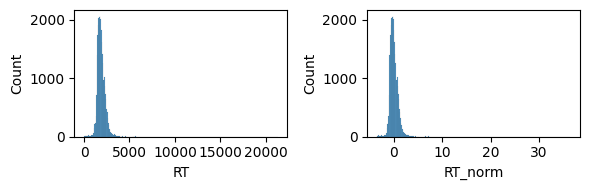

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2))

for i, col in enumerate(["RT", "RT_norm"]):
    sns.histplot(df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()

## 4. Model implementation and fitting

As an example, we will use the frameworks [jax](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html) and [numpyro](https://num.pyro.ai/en/stable/getting_started.html) here. Valid alternatives are [pymc](https://www.pymc.io/welcome.html) (similar interface) or [bambi](https://bambinos.github.io/bambi/) (very simple model definition uses pymc).

The procedure is the same for every framework and should (at least) cover the following:
0. Prepare your data - already done above
1. (optional) Split your data into a train and test set. The train set is used for parameter fitting, the test set for evaluating model predictions.
2. Define and implement your model
3. Fit your model
   1. Make sure the fitting converged
   2. Get an overview of the parameter values and their statements
4. Evaluate your model
   1. Make predictions
   2. Do model comparison

There are other steps, such as prior-predictive checks, not covered here.

In [13]:
# Hint: Before we fit a model, we need to make sure our dataset does not contain missing values!
assert (df.isna().sum() == 0).all()

### Baseline model
Let's start with implementing and fitting our baseline model.

In [14]:
def model_baseline(angle, time, group, choice=None):
    # define prior distributions of weights
    theta = npr.sample("theta", dist.Normal(0, 1))
    alpha = npr.sample("alpha", dist.Normal(0, 1))
    beta = npr.sample("beta", dist.Normal(0, 1))
    gamma = npr.sample("gamma", dist.Normal(0, 1))

    logits = theta + alpha * angle + beta * time + gamma * group

    if choice is None:
        # inspired by this numpyro example: https://num.pyro.ai/en/stable/examples/ucbadmit.html
        probs = expit(logits)
        npr.sample("probs", dist.Delta(probs), obs=probs)
    npr.sample("choice", dist.Bernoulli(logits=logits), obs=choice)
    # could alternatively do
    # probs = npr.deterministic("probs", expit(logits))
    # dist.Bernoulli(probs=probs)

A model is fitted using MCMC (Markov Chain Monte Carlo) Sampling, usually with the NUTS (no U-turn sampling) algorithm. <br>
These parameters should be the same for every model you fit and compare:

In [15]:
num_warmup = 500
num_samples = 1000
num_chains = 2

And then we can fit our model

In [16]:
kernel = NUTS(model_baseline)
mcmc_baseline = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

# provide data as model parameters
rng_key, rng_key_ = random.split(rng_key)
mcmc_baseline.run(
    rng_key_, 
    angle=df["angle_norm"].values, 
    time=df["time_norm"].values,
    group=df["group"].astype(int).values,
    choice=df["causality_judgement"].values,
)

C:\Users\key\AppData\Local\Temp\ipykernel_17888\395323295.py:2: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_baseline = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample: 100%|██████████| 1500/1500 [00:08<00:00, 173.24it/s, 15 steps of size 2.97e-01. acc. prob=0.94]


And plot a little overview of the parameters' posterior distribution.

In [17]:
trace_baseline = az.from_numpyro(mcmc_baseline)
sum_fit_baseline = az.summary(trace_baseline)
sum_fit_baseline

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.400,0.038,-1.471,-1.327,0.001,0.001,1224.0,1067.0,1.0
beta,-2.021,0.039,-2.095,-1.953,0.001,0.001,1103.0,1050.0,1.0
gamma,-0.007,0.024,-0.053,0.038,0.001,0.001,1461.0,1327.0,1.0
theta,1.375,0.029,1.322,1.429,0.001,0.001,1105.0,940.0,1.0


**Parameter interpretation** 

Great, so what do $\theta$, $\alpha$, $\beta$ and $\gamma$ tell us? <br>
For angle and delay the model tells us:
* $\alpha < 0$: The higher the angle, the less likely the response "causal" becomes
* $\beta < 0$: The higher the angle, the less likely the response "causal" becomes

Regarding the intercepts, it says:
* $\theta > 0$: There is a general tendency to report "causal" rather than "non causal"
* $\gamma \approx 0$ (0 is contained in the 94 % highest density interval (HDI)): There is no grop difference in the general tendency to respond "causal".

### Interaction model
Equivalently, we can define and fit our interaction model

In [18]:
def model_interaction(angle, time, group, choice=None):
    # define prior distributions of weights
    theta = npr.sample("theta", dist.Normal(0, 1))
    alpha = npr.sample("alpha", dist.Normal(0, 1))
    alpha_g = npr.sample("alpha_g", dist.Normal(0, 1))
    beta = npr.sample("beta", dist.Normal(0, 1))
    beta_g = npr.sample("beta_g", dist.Normal(0, 1))
    gamma = npr.sample("gamma", dist.Normal(0, 1))
    
    logits = theta + (alpha + alpha_g * group) * angle + (beta + beta_g * group) * time + gamma * group

    if choice is None:
        probs = expit(logits)
        npr.sample("probs", dist.Delta(probs), obs=probs)
    npr.sample("choice", dist.Bernoulli(logits=logits), obs=choice)

# we use the same number of burn ins, samples and chains as above
kernel = NUTS(model_interaction)
mcmc_interaction = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

# provide data as model parameters
rng_key, rng_key_ = random.split(rng_key)
mcmc_interaction.run(
    rng_key_, 
    angle=df["angle_norm"].values, 
    time=df["time_norm"].values,
    group=df["group"].astype(int).values,
    choice=df["causality_judgement"].values,
)

trace_interaction = az.from_numpyro(mcmc_interaction)
sum_fit_interaction = az.summary(trace_interaction)
sum_fit_interaction

C:\Users\key\AppData\Local\Temp\ipykernel_17888\671112547.py:19: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_interaction = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample: 100%|██████████| 1500/1500 [00:16<00:00, 90.37it/s, 15 steps of size 1.90e-01. acc. prob=0.94] 


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.802,0.057,-0.901,-0.690,0.002,0.001,717.0,1089.0,1.0
alpha_g,-1.209,0.083,-1.372,-1.065,0.003,0.002,743.0,898.0,1.0
beta,-2.932,0.064,-3.050,-2.815,0.002,0.001,758.0,1099.0,1.0
beta_g,1.702,0.084,1.546,1.853,0.003,0.002,769.0,988.0,1.0
gamma,-0.193,0.057,-0.294,-0.086,0.002,0.001,676.0,882.0,1.0
theta,1.486,0.041,1.404,1.559,0.002,0.001,670.0,765.0,1.0


**Parameter interpretation** 

Now we have to stop and think for a moment. Our group is encoded as 0 being HCs and 1 being SSDs. That means $\alpha$ and $\beta$ give us the weights for our healthy controls while $\alpha + \alpha_g$ and $\beta + \beta_g$ gives the weights for our SSD group!

Great, so what do $\alpha$, $\beta$ and $\gamma$ tell us?
* $\alpha < 0$: The higher the angle, the less likely the response "causal" becomes for the group HC
* $\alpha + \alpha_g < 0$: The same effect holds for the SSD group
* $\alpha_g < 0$: The effect of the angle is even stronger for SSDs than for HCs.
  
Similar we can proceed with parameter $\beta$:
* $\beta < 0$: The higher the angle, the less likely the response "causal" becomes for the group HC
* $\beta + \beta_g \approx -1.2 < 0$: The same effect holds for the SSD group
* $\beta_g > 0$: The effect of the delay is weaker for SSDs than for HCs.

Regarding the intercepts now we suddenly have a considerable effect for the group parameter!
* $\theta > 0$: There is a general tendency to report "causal" rather than "non causal"
* $\gamma < 0$: If the group is 1 (SSD) the response "causal" is generally less likely than if the group is 0 (HC).


## 5. Checking convergence and visualizing model parameter distributions

Whenever you fit a model, pay attention to the convergence metrics. In a nutshell:
* [Estimated sample size (ESS)](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): The higher the better. See also the [stan docs](https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html)
* [R_hat](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): The closer to 1.0 the better. Strongly increased r_hat values indicate bad convergence. Plot the parameter's posterior to visualize the problem.

For above example models both should look fine.

What we can also do is visualize our parameters' posterior distributions. If they look Gaussian in shape on visual inspection, that is already a good sign, at least regarding the convergence of our model.

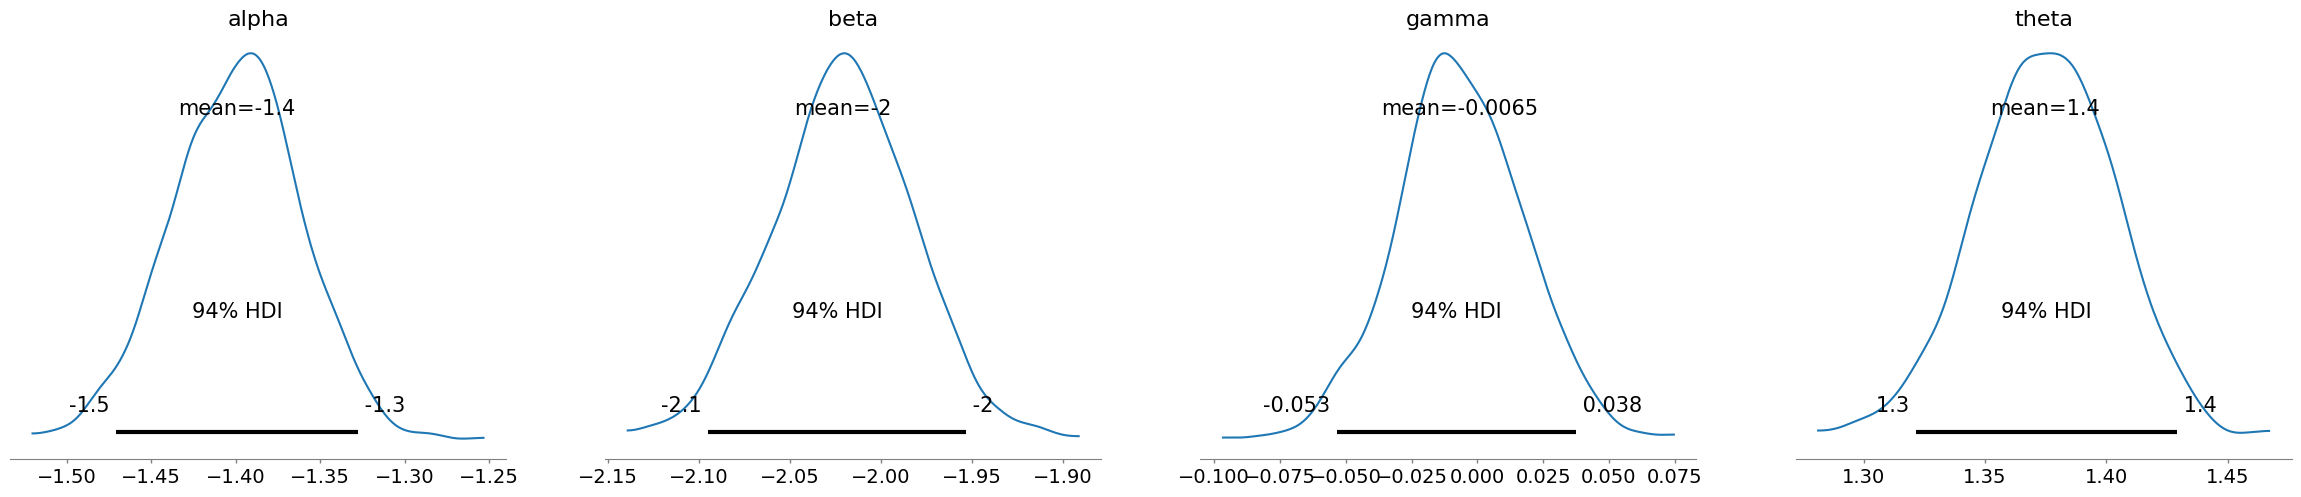

In [19]:
az.plot_posterior(trace_baseline)
plt.show()

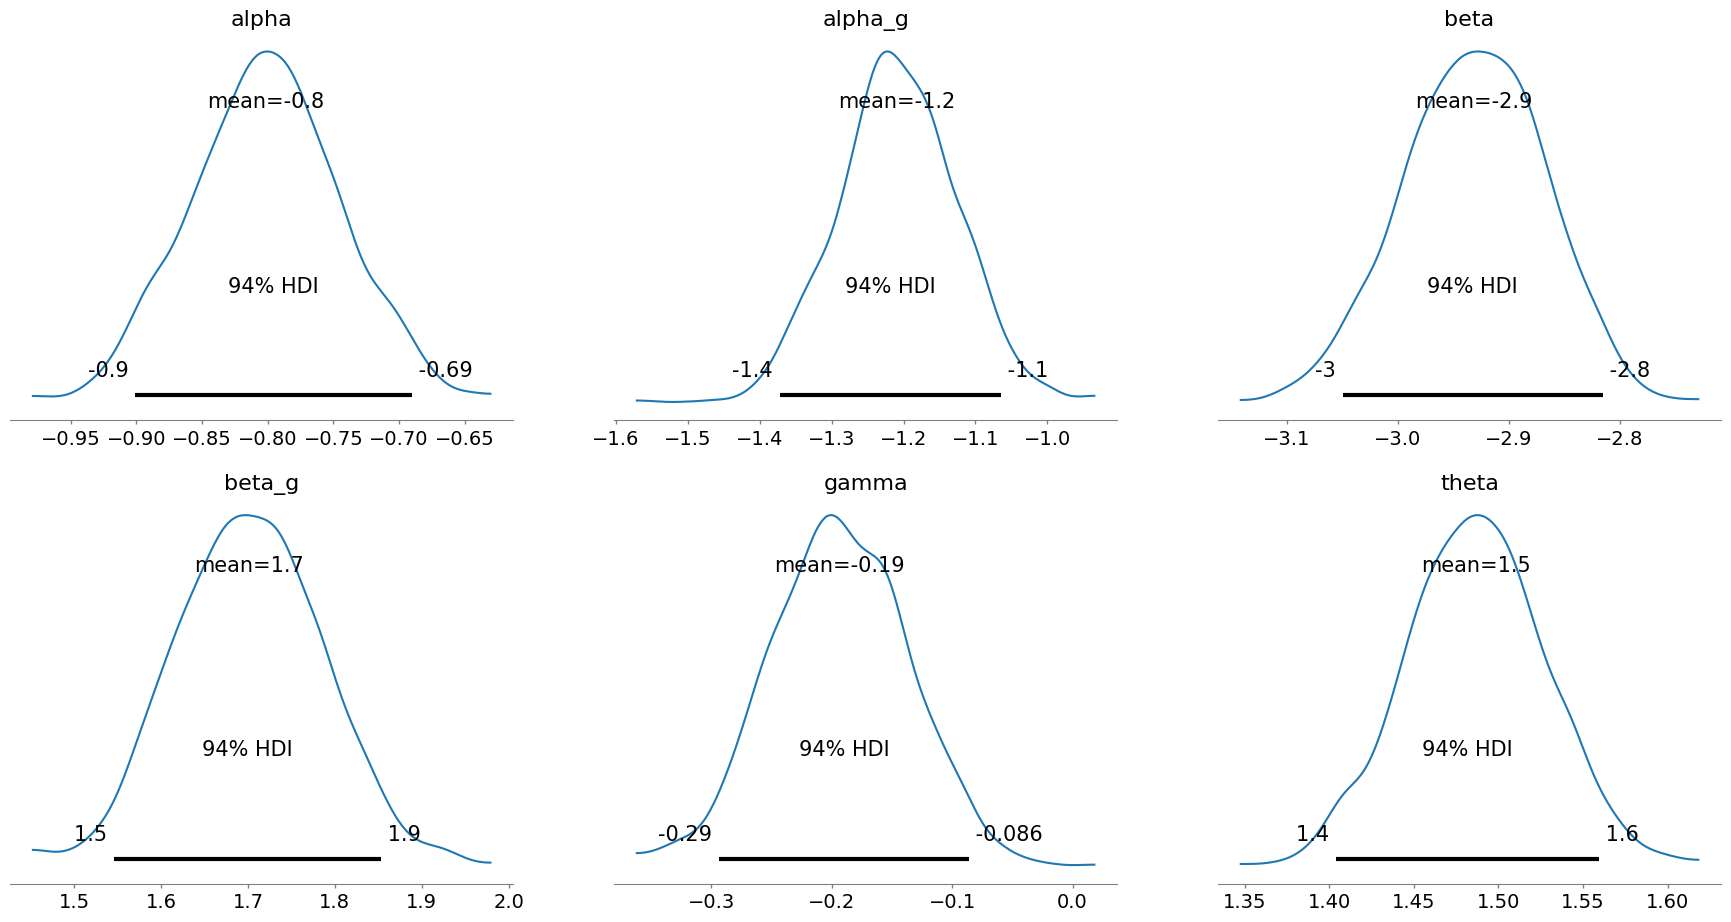

In [20]:
az.plot_posterior(trace_interaction)
plt.show()

### 5.1. (optional) Prior Predictive Checks

Right now, we have sufficient data to correct an the uninformative priors we chose (we set the initial influence of angle, delay and group to be 0 with some variance). To visualize the effect of our priors on the prediction, aka. what would the model predict without being fitted, we can do a prior-predictive check.

Hint: Run the cell multiple times to see that with each new random key (rng_key) the results slightly vary. Some priors are also quite unsensible, e.g. increasing causality ratings with increasing angle or delay...

grozuo: 0.0, color: purple
grozuo: 1.0, color: orange


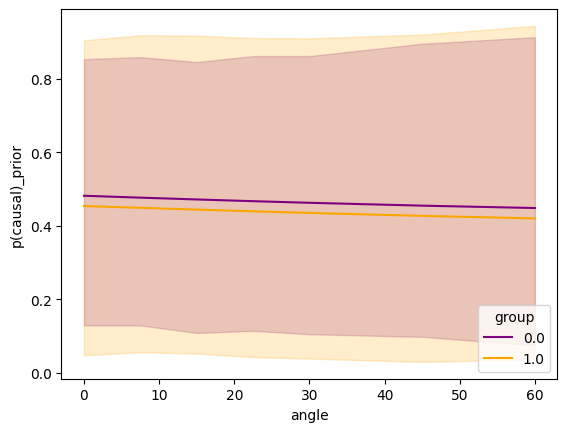

In [21]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

palette = ["purple", "orange"]

# Define the respective numpyro class
prior_predictive = Predictive(model_baseline, num_samples=100)

# make predictions based on our provided data (without fits)
rng_key, rng_key_ = random.split(rng_key)
prior_predictions = prior_predictive(rng_key_, df["angle_norm"].values, df["time_norm"].values, df["group"].astype(int).values)["probs"]

# take mean and HDI of the predictions
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.94) # highest posterior density interval

# plotting
# we create our plotting dataset
_pdf = df[["angle", "time", "group", "causality_judgement"]].copy()
# ... and assign the new values
_pdf["p(causal)_prior"] = mean_prior_pred
_pdf["p(causal)_prior_hdi3%"] = hpdi_prior_pred[0,:]
_pdf["p(causal)_prior_hdi97%"] = hpdi_prior_pred[1,:]

# Then we define the variable we want to plot,
var = "angle"

# group our data accordingly,
_pdf = _pdf.groupby([var, "group"]).mean().reset_index()

# and plot the prior mean
sns.lineplot(_pdf, x=var, y="p(causal)_prior", hue="group", palette=palette)
# and 94 % hdi
for i, g in enumerate(_pdf["group"].unique()):
    d = _pdf[_pdf["group"] == g]
    print(f"grozuo: {g}, color: {palette[i]}")
    plt.fill_between(d[var], d["p(causal)_prior_hdi3%"], d["p(causal)_prior_hdi97%"], color=palette[i], alpha=0.2)

plt.show()

We can observe two things:

1. Priors that allow the angle and delay weight to be positive really do not make much sense. Still, as stated above, our models are very capable to pick up on this from the data we provide
2. The way we have set up the group parameter gamma, our SSD group (coded as 1) starts with more uncertainty than our HC group (coded as 0)! <br>
    Since the standard deviations of each parameter are added up (see model definition above), the group uncertainty associated with $\gamma$ only affects the group coded as 1 (SSDs). That is at least something to be aware of. Luckily, however, it does not affect our results so far.

## 6. Making some predictions

In [22]:
# defime a color palette for plotting the groups HC (0, first color) and SSD (1, second color).
palette = ["purple", "orange"]

### Making simple mean based predictions

The naive way to get an intuition of how a model behaves is to let it make some simple predictions using the estimated parameter means.

**Baseline model** <br>

Our baseline model at least shows the right trends, but fails to really distinguish between the two groups. <br>
Hint: Play around the the plot to see the predictions for the delay as well.

,angle,time,group,causality_judgement,p(causal)
0,22.5,4.0,0.0,1.0,0.585344
1,30.0,0.0,0.0,1.0,0.662622


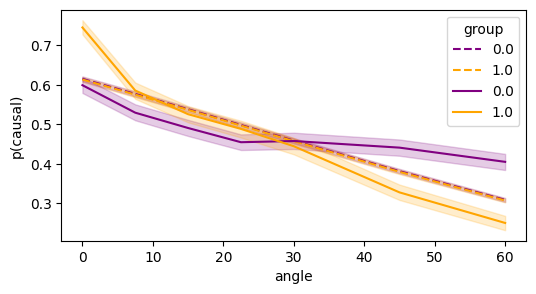

In [23]:
# make simple predictions
def lmm(theta, alpha, beta, gamma, angles, times, groups):
    logits = theta + alpha * angles + beta * times + gamma * groups
    return expit(logits)

params = [sum_fit_baseline.loc[param, "mean"] for param in ["theta", "alpha", "beta", "gamma"]]
values = df[["angle_norm", "time_norm", "group"]].values.T

# I use _pdf as something like "plottig data frame" to store my dataframe views and modifications in that are needed for the plot.
_pdf = df[["angle", "time", "group", "causality_judgement"]].copy()
_pdf["p(causal)"] = lmm(*params, *values)
display(_pdf.head(2))

# plotting
var = "angle"

fig, ax = plt.subplots(1,1, figsize=(6,3))
# predictions:
sns.lineplot(_pdf, x=var, hue="group", y="p(causal)", palette=palette, linestyle="--")
# data
sns.lineplot(_pdf, x=var, hue="group", y="causality_judgement", palette=palette)
plt.show()

**Interaction model** <br>

Agan, we can proceed equivalently for our interaction model and see the advantage of allowing different slopes (weights) for angle and delay for the two groups. The models' prediction look way better!

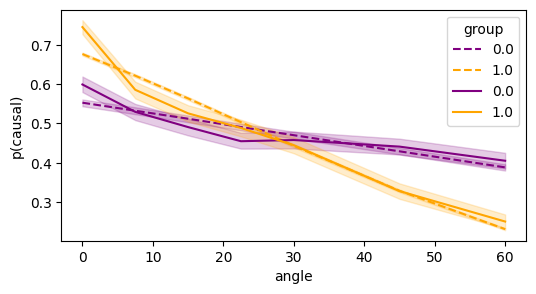

In [24]:
def lmm(theta, alpha, alpha_g, beta, beta_g, gamma, angles, times, groups):
    logits = theta + (alpha+alpha_g*groups) * angles + (beta+beta_g*groups) * times + gamma * groups
    return expit(logits)
params = [sum_fit_interaction.loc[param, "mean"] for param in ["theta", "alpha", "alpha_g", "beta", "beta_g", "gamma"]]
values = df[["angle_norm", "time_norm", "group"]].values.T

_pdf = df[["angle", "time", "group", "causality_judgement"]].copy()
_pdf["p(causal)"] = lmm(*params, *values)

# ---
var = "angle"
# ---

fig, ax = plt.subplots(1,1, figsize=(6,3))
sns.lineplot(_pdf, x="angle", hue="group", y="p(causal)", palette=palette, linestyle="--")
sns.lineplot(_pdf, x="angle", hue="group", y="causality_judgement", palette=palette)
plt.show()

Hint: As this approach is meant to be quick and dirty, the shaded area around the predictions, here is simply an artefact and should not be interpreted.

### Making posterior predictions with numpyro

We can use numpyro's Predictive class, which we have already used for prior-predictive checks to also make posterior predictions.

Baseline model

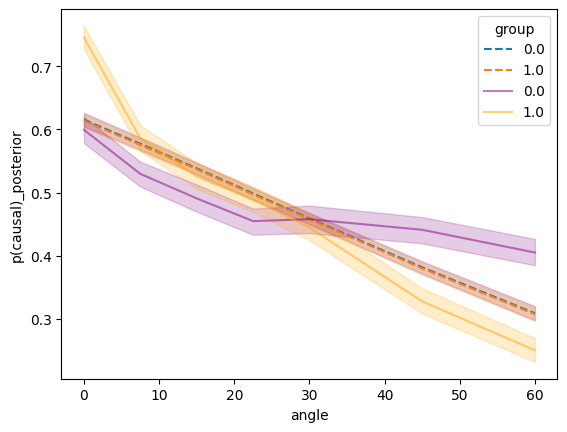

In [25]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

# Define the respective numpyro class
posterior_predictive = Predictive(model_baseline, posterior_samples=mcmc_baseline.get_samples(), num_samples=2000)

# make predictions based on our provided data (without fits)
rng_key, rng_key_ = random.split(rng_key)
posterior_predictions = posterior_predictive(rng_key_, df["angle_norm"].values, df["time_norm"].values, df["group"].astype(int).values)["probs"]

# take mean and HDI of the predictions
mean_posterior_pred = jnp.mean(posterior_predictions, axis=0)
hpdi_posterior_pred = hpdi(posterior_predictions, 0.94) # highest posterior density interval

# plotting
# we create our plotting dataset
_pdf = df[["angle", "time", "group", "causality_judgement"]].copy()
# ... and assign the new values
_pdf["p(causal)_posterior"] = mean_posterior_pred
_pdf["p(causal)_posterior_hdi3%"] = hpdi_posterior_pred[0,:]
_pdf["p(causal)_posterior_hdi97%"] = hpdi_posterior_pred[1,:]

# Then we define the variable we want to plot,
var = "angle"

# group our data accordingly,
_pdf = _pdf.groupby([var, "group"]).mean().reset_index()

# and plot the posterior mean
sns.lineplot(_pdf, x=var, y="p(causal)_posterior", hue="group", color="red", linestyle="--")
# and 94 % hdi
for i, g in enumerate(_pdf["group"].unique()):
    d = _pdf[_pdf["group"] == g]
    plt.fill_between(d[var], d["p(causal)_posterior_hdi3%"], d["p(causal)_posterior_hdi97%"], color=palette[i], alpha=0.2)

# also add data:
sns.lineplot(df, x=var, y="causality_judgement", hue="group", palette=palette, alpha=0.5)

plt.show()

Interaction Model <br>
And again, we just reuse the code above to create the same plot but with predictions from the interaction model. 

If you intend to copy this code, please first put it into a function.

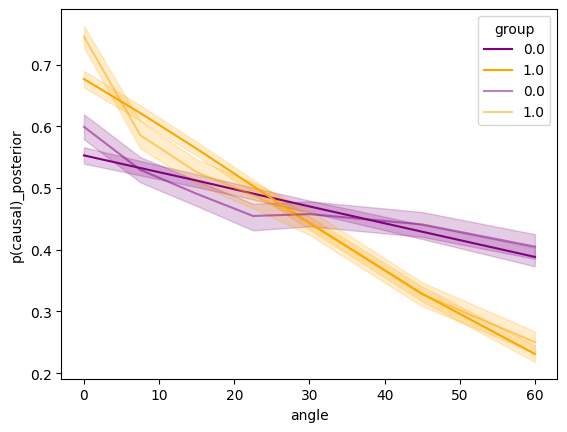

In [26]:
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

# Define the respective numpyro class
posterior_predictive = Predictive(model_interaction, posterior_samples=mcmc_interaction.get_samples(), num_samples=2000)

# make predictions based on our provided data (without fits)
rng_key, rng_key_ = random.split(rng_key)
posterior_predictions = posterior_predictive(rng_key_, df["angle_norm"].values, df["time_norm"].values, df["group"].astype(int).values)["probs"]

# take mean and HDI of the predictions
mean_posterior_pred = jnp.mean(posterior_predictions, axis=0)
hpdi_posterior_pred = hpdi(posterior_predictions, 0.94) # highest posterior density interval

# plotting
# we create our plotting dataset
_pdf = df[["angle", "time", "group", "causality_judgement"]].copy()
# ... and assign the new values
_pdf["p(causal)_posterior"] = mean_posterior_pred
_pdf["p(causal)_posterior_hdi3%"] = hpdi_posterior_pred[0,:]
_pdf["p(causal)_posterior_hdi97%"] = hpdi_posterior_pred[1,:]

# Then we define the variable we want to plot,
var = "angle"

# group our data accordingly,
_pdf = _pdf.groupby([var, "group"]).mean().reset_index()

# and plot the posterior mean
sns.lineplot(_pdf, x=var, y="p(causal)_posterior", hue="group", color="red", palette=palette)
# and 94 % hdi
for i, g in enumerate(_pdf["group"].unique()):
    d = _pdf[_pdf["group"] == g]
    plt.fill_between(d[var], d["p(causal)_posterior_hdi3%"], d["p(causal)_posterior_hdi97%"], color=palette[i], alpha=0.2)

# also add data:
sns.lineplot(df, x=var, y="causality_judgement", hue="group", palette=palette, alpha=0.5)

plt.show()

## 7. Model comparison

Finally, we can ask: What model is better?

Sure, from our visualizations above, we have already a strong expectation, however, there can be cases, when the fit is less obvious and we need other metrics than our eyes to make an informed decision. Such metrics we can get by running model comparison. Implementation is again quite straight forward using arviz.

In [27]:
comparison = az.compare({
    "baseline": trace_baseline,
    "interaction": trace_interaction
})
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
interaction,0,-19116.049440,6.442889,0.000000,0.985641,66.836359,0.000000,False,log
baseline,1,-19511.332171,4.036611,395.282732,0.014359,61.691900,28.149295,False,log


You can read more about the process and each metric, for example [here](https://python.arviz.org/en/stable/api/generated/arviz.compare.html).
<br>
For application there are two main points you need to pay attention to:
1. Obviously, the higher a model's rank, the better its overall fit according to the estimated metrics.
2. You also need to pay attention to the difference between the models' ranks. <br>
    E.g., Look at the elpd difference of the models and the standard error of the elpd estiamte (`se`). <br> Simply put, if the ``se`` is higher than or close to the ``elpd_diff``, there is little confidence in this ranking.

## 8. What is left to do

Now it's your turn to get creative. You have seen here but one of many approaches to model causality judgements. It should give you the tools to build up on and explore other ideas. What else could play a role and how can you capture this in an equation? Or would you rather think about how to predict a particpant's reaction time? <br>
It' up to you!

If you decide to model causality judgements, try to compare your approach to the interaction model presented here to see if you could get better! <br>
For that to work you need to use the same amount of samples.

Good coding!